# Use RDataFrame with xAODs + awkward array

Possible setup to run this notebook (in a centos7 environment with cvmfs):

**Install**
```sh
setupATLAS
asetup AnalysisBase,22.2.74
export PYTHONNOUSERSITE=1 # we want to put all extra packages into a virtualenv (ignore user site packages)
# --system-site-packages will help to only install what is not yet in the ATLAS environment
python -m venv --system-site-packages .extra-packages-AnalysisBase-22.2.74
source .extra-packages-AnalysisBase-22.2.74/bin/activate
# since the ATLAS setup uses PYTHONPATH we also put the extra-packages dir in front
# to prioritize packages from there if nescessary
export PYTHONPATH=$(pwd)/.extra-packages-AnalysisBase-22.2.74/lib/python3.9/site-packages:$PYTHONPATH
# now install extra packages
pip install jupyterlab awkward vector matplotlib
```

**Setup next time**
```sh
setupATLAS
asetup AnalysisBase,22.2.74
export PYTHONNOUSERSITE=1
source .extra-packages-AnalysisBase-22.2.74/bin/activate
export PYTHONPATH=$(pwd)/.extra-packages-AnalysisBase-22.2.74/lib/python3.9/site-packages:$PYTHONPATH
```

**Run with**
```sh
jupyter lab
```

In [1]:
import ROOT
import awkward as ak
import numpy as np
import vector
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/06


following Attila's presentation https://indico.cern.ch/event/1140386/

Also see https://gitlab.cern.ch/akraszna/xAODDataSource/-/tree/master/xAODDataFrameTests/util

In [2]:
ROOT.xAOD.Init().ignore()
#ROOT.ROOT.EnableImplicitMT() # haven't gotting this working yet with decorators
from xAODDataSource.Helpers import MakexAODDataFrame

# instantiate needed container types
ROOT.xAOD.ElectronContainer()

<cppyy.gbl.DataVector<xAOD::Electron_v1> object at 0x1d1b9120>

xAOD::Init                INFO    Environment initialised for data access


In [3]:
import urllib
import os

# 10k events, 140MB
# produced from mc16_13TeV:AOD.13122612._000001.pool.root.1
# from ttbar sample mc16_13TeV:mc16_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.merge.AOD.e6337_e5984_s3126_r10201_r10210
filename = "user.nihartma.22884623.EXT0._000001.DAOD_PHYSLITE.test.pool.root"
if not os.path.exists(filename):
    print("downloading ...")
    urllib.request.urlretrieve(
        "https://cernbox.cern.ch/index.php/s/3Il7P7MJ0aAeyJG/download", filename
    )

In [4]:
rdf = MakexAODDataFrame(filename)

In [ ]:
list(rdf.GetColumnNames())

In [6]:
rdf.GetColumnType("AnalysisElectrons")

'DataVector<xAOD::Electron_v1>'

In [7]:
rdf2 = rdf.Define("el_pt_0", "AnalysisElectrons.size() > 0 ? AnalysisElectrons[0]->pt() : -999")

In [8]:
rdf2.AsNumpy(["el_pt_0"])

{'el_pt_0': ndarray([  -999.        ,   3373.38525391,  67384.453125  , ...,
          100287.59375   ,  25825.640625  ,   6266.61523438])}

input_line_455:10:7: warning: ignoring return value of function declared with 'nodiscard' attribute [-Wunused-result]
      ((const vector<double>*)obj)->empty();
      ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [9]:
rdf2 = rdf.Define("el_pt_0", "AnalysisElectrons.size() > 0 ? AnalysisElectrons[0]->trackParticle()->pt() : -999")
rdf2.AsNumpy(["el_pt_0"])

{'el_pt_0': ndarray([ -999.        ,  4129.17535388, 32111.68112368, ...,
          91299.6962074 ,  2382.70603923,  5681.07067736])}

To use nested types we have to convert to an `awkward` array. A conversion function from `RDataFrame` to `awkward` [is in the works](https://github.com/scikit-hep/awkward/pull/1448). Until then, we can manually convert it using `RDataFrame.Take`:

In [10]:
rdf3 = rdf.Define("el_track_pt", """
std::vector<float> pt;
for (auto electron: AnalysisElectrons) {
  pt.push_back(electron->trackParticle()->pt());
}
return pt;
""")

In [11]:
rdf3.GetColumnType("el_track_pt")

'vector<float>'

In [12]:
ak_pt = ak.Array(rdf3.Take[rdf3.GetColumnType("el_track_pt")]("el_track_pt"))

In [ ]:
ak_pt.tolist()

This was using a python loop - we can be a bit more efficient by defining a c++ function that splits the array into offsets and a flat content:

In [14]:
%%cpp -d
template <typename T>
std::pair<std::vector<int64_t>, std::vector<T>>
flatten(std::vector<std::vector<T>> vv) {
  std::vector<int64_t> offsets;
  std::vector<T> content;
  offsets.reserve(1024);
  content.reserve(1024);
  int i = 0;
  for (auto v : vv) {
    offsets.push_back(i);
    for (auto x : v) {
      content.push_back(x);
      i++;
    }
  }
  offsets.push_back(i);
  return std::make_pair(offsets, content);
}

In [15]:
vv = rdf3.Take[rdf3.GetColumnType("el_track_pt")]("el_track_pt")

In [16]:
offsets, content = ROOT.flatten["float"](vv.GetValue())

In [17]:
np.array(content)

array([ 4129.1753, 32111.682 , 76299.625 , ...,  5203.103 ,  2382.706 ,
        5681.071 ], dtype=float32)

input_line_484:10:7: warning: ignoring return value of function declared with 'nodiscard' attribute [-Wunused-result]
      ((const vector<float>*)obj)->empty();
      ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [18]:
np.array(offsets)

array([   0,    0,    1, ..., 4727, 4728, 4729])

input_line_488:10:7: warning: ignoring return value of function declared with 'nodiscard' attribute [-Wunused-result]
      ((const vector<long>*)obj)->empty();
      ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [19]:
def vv_to_ak(vv, typename):
    if hasattr(vv, "GetValue"):
        vv = vv.GetValue()
    offsets, content = ROOT.flatten[typename](vv)
    return ak.Array(
        ak.layout.ListOffsetArray64(
            ak.layout.Index64(np.array(offsets.data())),
            ak.layout.NumpyArray(np.array(content.data())),
        )
    )

In [20]:
def vv_rdf_to_ak(rdf, columns):
    col_takes = {}
    col_basetypes = {}
    for column in columns:
        col_type = rdf.GetColumnType(column)
        col_basetypes[column] = col_type.split("<")[1].split(">")[0]
        col_takes[column] = rdf.Take[col_type](column)
    array = {}
    for column in columns:
        array[column] = vv_to_ak(col_takes[column], col_basetypes[column])
    return ak.zip(array)

In [21]:
vv_rdf_to_ak(rdf3, ["el_track_pt"])

<Array [[], ... {el_track_pt: 5.68e+03}]] type='10000 * var * {"el_track_pt": fl...'>

We can then also pull out whole 4-momentum vectors, e.g.

In [22]:
def get_collection_4mom(rdf, collection):
    columns = ["pt", "eta", "phi", "e"]
    for column in columns:
        rdf = rdf.Define(column, """
std::vector<float> res;
res.reserve(%(collection)s.size());
for (auto particle: %(collection)s) {
  res.push_back(particle->%(column)s());
}
return res;
""" % dict(column=column, collection=collection))
    return vector.awk(vv_rdf_to_ak(rdf, columns))

In [23]:
electrons = get_collection_4mom(rdf, "AnalysisElectrons")

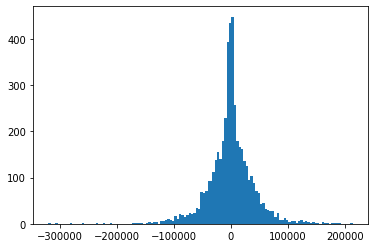

In [24]:
plt.hist(ak.flatten(electrons.px).to_numpy(), bins="auto");

In [25]:
jets = get_collection_4mom(rdf, "AnalysisJets")

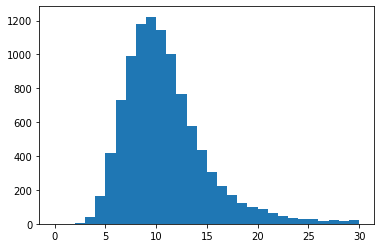

In [26]:
plt.hist(ak.num(jets), bins=30, range=(0, 30));

In [27]:
f = ROOT.TFile.Open(filename)

In [ ]:
list(branch.GetName() for branch in f.Get("CollectionTree").GetListOfBranches() if branch.GetName().startswith("AnalysisElectrons"))

In [29]:
rdf5 = rdf.Define("topoetcone20", """
static const SG::AuxElement::ConstAccessor<float> acc("topoetcone20");
std::vector<float> dec;
for (auto electron: AnalysisElectrons) {
    dec.push_back(acc(*electron));
}
return dec;
""")

In [30]:
topoet = vv_rdf_to_ak(rdf5, ["topoetcone20"])

In [31]:
topoet[:10].tolist()

[[],
 [{'topoetcone20': 4930.9033203125}],
 [{'topoetcone20': 1272.5250244140625}],
 [],
 [{'topoetcone20': 1824.3009033203125}],
 [{'topoetcone20': 5487.00390625}],
 [],
 [],
 [],
 [{'topoetcone20': -757.2159423828125}]]

In [32]:
ak_pt[:10].tolist()

[[],
 [4129.17529296875],
 [32111.681640625],
 [],
 [76299.625],
 [5160.49609375],
 [],
 [],
 [],
 [10969.140625]]